In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
h5py.enable_ipython_completer()

In [2]:
from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.hdf5 as io

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/syndat/scattering_theory.py:178: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(orbital_angular_momentum == 0, "Phase shift function in syndat.scattering theory needs to be updated for higher-order waveforms")


In [3]:
# syndat.particle_pair()

In [4]:
%matplotlib widget

In [5]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})


In [6]:
# create an energy domain, min/max
E_min_max = [550, 600]
# E_min_max =[3.5, 2550]

### or just give the min/max and the experiment object will do the above
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

181

In [7]:
case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/test.hdf5'
dataset_range = (0, 10)
spin_groups = [ (3.0,1,0) ]
# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups )    

# vary_Erange = {'fullrange':(3,1000), 'maxres':5 , 'prob':0.01}
vary_Erange = None

samples_not_generated = generate(Ta_pair, exp, 
                                    'syndat_SLBW', 
                                    dataset_range, 
                                    case_file,
                                    fixed_resonance_ladder=None, 
                                    open_data=None,
                                    vary_Erange=vary_Erange,
                                    use_hdf5=True,
                                    overwrite = True
                                                                )

In [8]:

def take_syndat_spingroups(theo_par_df, est_par_df):
    if all(item in est_par_df.columns for item in ['J', 'chs', 'lwave', 'J_ID']):
        pass
    else:
        standard_spingroups = np.array([theo_par_df[['J', 'chs', 'lwave', 'J_ID']].iloc[0]])
        est_par_df[['J', 'chs', 'lwave', 'J_ID']] = np.repeat(standard_spingroups, len(est_par_df), axis=0)
    return est_par_df

def get_initial_guess_from_levels(E_levels, Gg_, gn2_):
    ires = len(E_levels)
    initial_res_ladder = pd.DataFrame({'E'      :   E_levels, 
                                       'Gg'     :   [Gg_]*ires,
                                       'gnx2'   :   [gn2_]*ires,
                                       })
    return initial_res_ladder

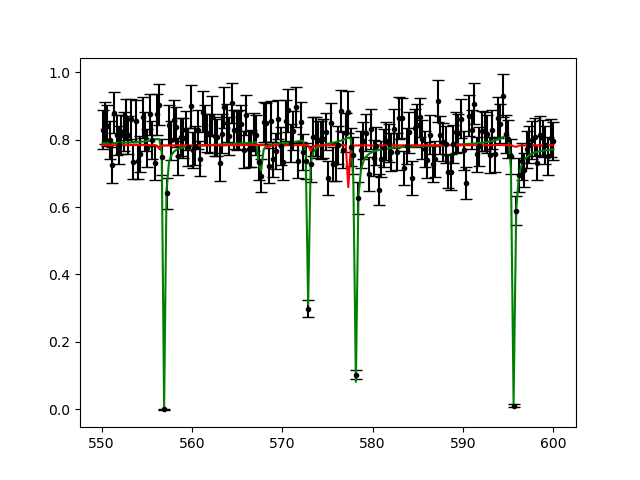

In [9]:
from ATARI.syndat.scattering_theory import SLBW

isample = 1
exp_pw, exp_cov = io.read_experimental(case_file, isample) 
theo_pw, theo_par = io.read_theoretical(case_file, isample)

initial_guess_Elam = theo_par.E + np.random.default_rng().normal(0, scale=0.5, size = len(theo_par.E))

resonance_ladder_0 = get_initial_guess_from_levels(initial_guess_Elam, 40, 1)
resonance_ladder_0 = take_syndat_spingroups(theo_par, resonance_ladder_0)


tot, scat, cap = SLBW(exp_pw.E, Ta_pair, resonance_ladder_0)
trans = np.exp(-exp.redpar.val.n*tot)

figure()
errorbar(exp_pw.E, exp_pw.exp_trans, yerr=np.sqrt(np.diag(exp_cov)), fmt='.', color='k', capsize=4)
plot(exp_pw.E, exp_pw.theo_trans, color='g')
plot(exp_pw.E, trans, color='r')

In [21]:
exp.redpar.val.n

0.067166

In [11]:
def func(val):
    if isinstance(val, list):
        return val
    else:
        return [val]
resonance_ladder_0['lwave'] = resonance_ladder_0['lwave'].apply(func)
resonance_ladder_0


,E,Gg,gnx2,J,chs,lwave,J_ID
0,557.652908,40,1,3.0,1.0,[0.0],1.0
1,571.410431,40,1,3.0,1.0,[0.0],1.0
2,577.040103,40,1,3.0,1.0,[0.0],1.0
3,580.197075,40,1,3.0,1.0,[0.0],1.0
4,593.031952,40,1,3.0,1.0,[0.0],1.0
5,599.829500,40,1,3.0,1.0,[0.0],1.0


In [16]:

from ATARI.syndat.sammy_interface import solve_bayes

lst = solve_bayes(exp_pw, exp_cov, resonance_ladder_0, Ta_pair,
                                                model   = 'SLBW',
                                                reaction = 'trans',
                                                expertimental_corrections = 'no_exp',
                                                sammy_runDIR='SAMMY_runDIR',
                                                keep_runDIR = True  
                                                                                        )

In [25]:

from ATARI.syndat.sammy_interface import readlst
lst = readlst('/Users/noahwalton/Documents/GitHub/ATARI/Fitting/fitting_lite/SAMMY_runDIR/SAMMY.LST')

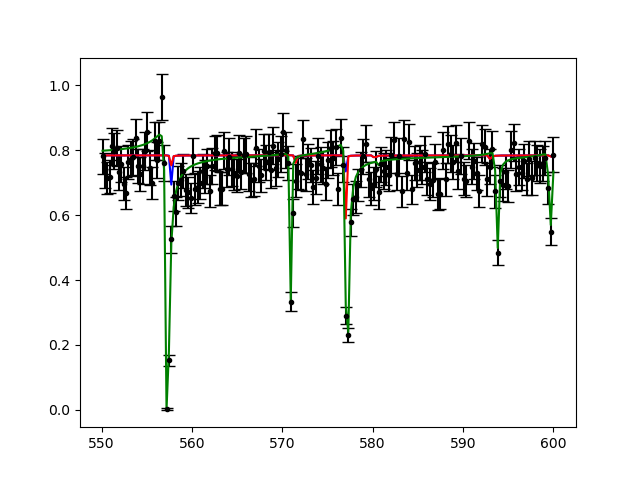

In [27]:
figure()
errorbar(lst.E, lst.exp_trans, yerr=lst.exp_trans_unc, fmt='.', color='k', capsize=4)
plot(lst.E, lst.theo_trans, color='b')
plot(lst.E, lst.theo_trans_bayes, color='r')
plot(exp_pw.E, exp_pw.theo_trans, color='g')